In [22]:
# too many "probably yes" turkers mistaking solensimilia for dianthus.

# change the instructions, new labeling jobs . doubt when say yes
# jess relabel
# ridge run (solensomilia)
# plot experts against eac other
# look at the actual images
# another approach: object detection

# we want strip over sea floor with a score and a error bar
# how to calibrate 
# normalize on y
# dependencies

# ordered in time
# correlation coefficient from jess's (sensitivity, just on expert data) --> use smoothing . 
# dive by dive (another camera)
# new england sea mounts (much less solensomilia)

# spatial coherence
# turks dont have spatial coherence (do they link things together in time)

# take map information 
from sklearn.metrics import confusion_matrix
import ast
import boto3
import glob
import os, json, yaml, re, requests
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve


labels = {
  "Definitely no": 1,
    "Probably no": 2,
    "Probably yes": 3,
  "Definitely yes": 4
}

In [2]:
#create dictionary mapping image file (0 to 229) to 6-digit image ID in "images"

images = {}
with open('annotations.manifest', 'r') as input_fid:
        pred = input_fid.readlines()
for p in pred:
#     print(repr(p))
    idx = re.search('[0-9]+', p).group()
#     print(idx)
    images[int(idx)] = int(p.rsplit('/', 1)[-1][:6])
with open('ann_2.manifest', 'r') as input_fid:
        pred = input_fid.readlines()
# print(pred)
for p in pred:
#     print(repr(p))
    idx = re.search('[0-9]+', p).group()
#     print(idx)
    images[int(idx)] = int(p.rsplit('/', 1)[-1][:6])
    

In [3]:
#create dictionaries: 
    # 1) from image ID to annotations by all 9 workers (turk_labels)
    # 2) from workerID to their annotations (workers)


# get raw annotations
annotations = {}


s3 = boto3.resource('s3')
mybucket = s3.Bucket("myra-exp-outputs")
bucket_prefix="test-label-dianthus/annotations/worker-response"
objs = mybucket.objects.filter(
    Prefix = bucket_prefix)

for obj in objs:
    path, filename = os.path.split(obj.key)
    try:
        os.makedirs(path) 
    except FileExistsError:
        pass
#     obj.get()['Key'].read
    parent = path.rsplit('/', 1)[-1]
    parent = int(parent)
    content = ast.literal_eval(obj.get()['Body'].read().decode('utf-8'))
    annotations[parent] = content

#     map ID to 9 diff ratings
turk_labels = {}

# print(len(annotations))
for key, ann in annotations.items():
#     score = 0
    imFn = images[key]
    for ea in ann['answers']:
        label = ea['answerContent']['crowd-image-classifier']['label']
        lbl = labels[label]
        if imFn in turk_labels.keys():
            turk_labels[imFn].append(lbl)
        else:
            turk_labels[imFn] = [lbl]
        
# map worker to their ratings
workers = {}
for key, ann in annotations.items():
    for ea in ann['answers']:
        workerId = ea['workerId']
        label = ea['answerContent']['crowd-image-classifier']['label']
        score = labels[label]
        if workerId in workers.keys():
            workers[workerId].append(score)
        else:
            workers[workerId] = [score]
        

229


In [4]:
# distribution (doesnt make sense)
# for wId, series in workers.items():
#     series = np.sort(series)
# #     print(series)
#     p1 = 12.5
#     p2 = 37.5
#     p3 = 62.5
#     p4 = 87.5

#     q1 = np.percentile(series,  p1)
#     q2 = np.percentile(series,  p2)
#     q3 = np.percentile(series,  p3)
#     q4 = np.percentile(series,  p3)
# #     print(q1)

In [5]:
# create jess's labels for PR curve and CM

expert_imlabels = {}

idx = 1
mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'

# load and refactor the annotation data
json_pattern = 'jess-annotations.json'
file_list = glob.glob(json_pattern)
for file in file_list:
    annotations = json.load(open(file))
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
    #     print(imIds[0])
        expert_imlabels[imFn] = int(ann['answers']['dianthus'])
# print(expert_imlabels)

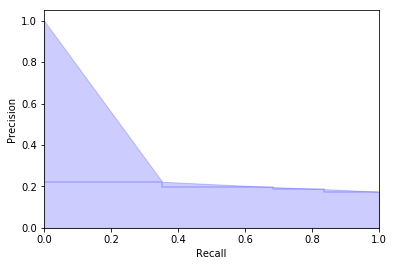

TypeError: 'int' object is not subscriptable

In [90]:
# draw precision-recall curve by mapping from 4 classes to binary decision with indiv workers vs. jess
y = []
y_ims = []
gt = []

# compare to Jess
for im in expert_imlabels:
        for val in turk_labels[im]:
            y.append(val/4.0)
            y_ims.append(im)
            gt.append(int(expert_imlabels[im]/4 + 0.25))
            
precision, recall, thresholds = precision_recall_curve(gt, y)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# compare to last one in imlabels
y = []
gt = []
for im in expert_imlabels:
        for val in turk_labels[im]:
            y.append(val/4.0)
            gt.append(int(imlabels[im][0]/4 + 0.25))
            
precision, recall, thresholds = precision_recall_curve(gt, y)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# print(gt)


In [93]:

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     print(cm.shape)

    classes = labels.items()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        print(np.sum(np.diagonal(cm)))
#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


1.0829316538032134
[837161, 837851, 837261, 837601, 837181, 836321, 836201, 837001, 836331, 836461, 837171, 836191, 837351, 835821, 835721, 837471, 837711, 836121, 836581, 837491, 837331, 836291, 837381, 836041, 837921, 837561, 836111, 837571, 837821, 835711, 836221, 836181, 836151, 836001, 837041, 836091, 836311, 837881, 835691, 835731, 837731, 837371, 835741, 837871, 836281, 837861, 837951, 836601, 837391, 836381, 836271, 836301, 836071, 836171, 837071, 836531, 836141, 837931, 837151, 836011, 836061, 837341, 837891, 836341, 835681, 837301, 836241, 835701, 836491, 836371, 836921, 836161, 837511, 836591, 836231, 837651, 836441, 837631, 835851, 836131, 837501, 837831, 837521, 837271, 837811, 836101, 837311, 837791, 837911, 836211, 837291, 837611, 836261, 836361, 836451, 837131, 836511, 837221, 836081, 836251, 837281, 836571, 836351, 836501]


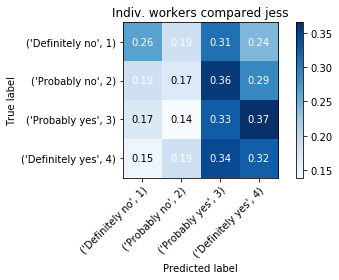

In [112]:
# plot confusion matrix of indiv. workers' labels compared to Jess's labels
y = []
y_im = []
gt = []

for im in expert_imlabels:
        for val in turk_labels[im]:
            y_ims.append(im)
            y.append(val)
            gt.append(expert_imlabels[im])

# print(len(y))
# print(len(gt))
plot_confusion_matrix(gt, y, True, 'Indiv. workers compared jess')

inv_map = {v: k for k, v in annIdToImId.items()}
prob_ims = []
for i, im in enumerate(y):
    if y[i] == 3 and gt[i] == 1:
#         name = inv_map[y_ims[i]]
        name = y_ims[i]

        if name not in prob_ims:
            prob_ims.append(name)
print(prob_ims)


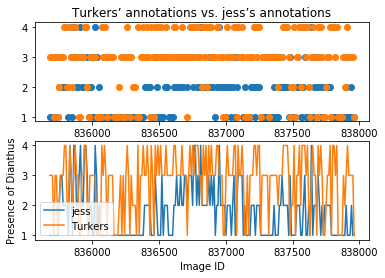

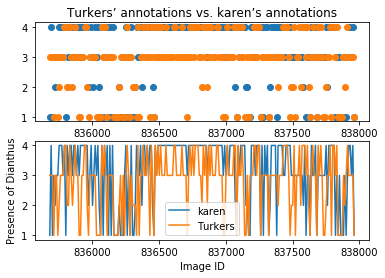

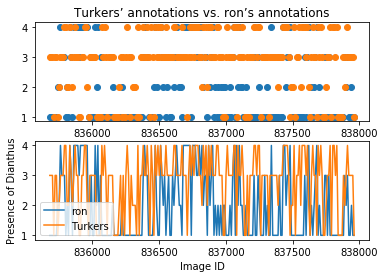

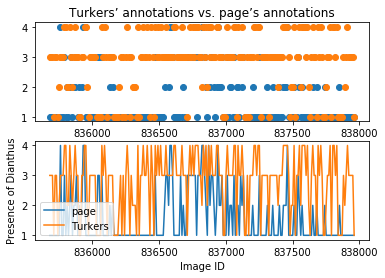

In [100]:
# visualization to compare turkers' average annotations with experts' annotations



imlabels = {}
idx = 1
mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'

# load and refactor the annotation data
json_pattern = '*annotations.json'
file_list = glob.glob(json_pattern)
for file in file_list:
    imlabels = {}

    annotations = json.load(open(file))
    # print(annotations)

    # read from expert annotations
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
    #     print(imIds[0])
        if imFn in imlabels.keys():
            imlabels[imFn].append(int(ann['answers']['dianthus']))
        else:
            imlabels[imFn] = [int(ann['answers']['dianthus'])]


# read from turkers labels
    with open('output.manifest', 'r') as input_fid:
        pred = input_fid.readlines()
        det = [ast.literal_eval(x.strip('\n')) for x in pred]

    # print(det[1]['source-ref'][26:32]) #name
    # print(det[1]['test-label-dianthus-metadata']['confidence'])
    # print(labels[det[1]['test-label-dianthus-metadata']['class-name']])

    for item in det:
        imFn = int(item['source-ref'][26:32])
        label = int(labels[item['test-label-dianthus-metadata']['class-name']])
        confidence = float(item['test-label-dianthus-metadata']['confidence'])

    #     imlabels[imFn].append(label * confidence)
        imlabels[imFn].append(label)

    %matplotlib inline
    

    # plt.plot(imlabels.keys(),y)
    lists = sorted(imlabels.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    # plt.plot(x, y[0])
    legend = [file.split('-')[0], "Turkers"]
    idx = 1
    plt.subplot(2, 1, 1)
    plt.title('Turkers’ annotations vs. %s’s annotations' % legend[0] )

    idx += 1
    for i in range(len(y[0])):
        plt.plot(x,[pt[i] for pt in y], 'o', label = legend[i])
#     plt.legend()
#     plt.xlabel('Image ID')
#     plt.ylabel('Presence of Dianthus')
#     plt.figure()
    plt.subplot(2, 1, 2)

    for i in range(len(y[0])):
        plt.plot(x,[pt[i] for pt in y], label = legend[i])


    plt.legend()
    plt.xlabel('Image ID')
    plt.ylabel('Presence of Dianthus')

    plt.show()

# print(x)

1.236142546487374
1.4267592715868578
1.1164588233553752
1.0954304057752335
916


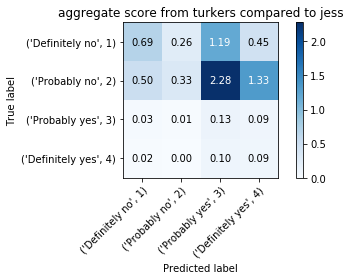

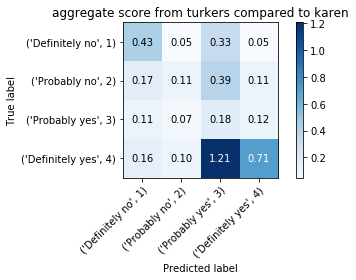

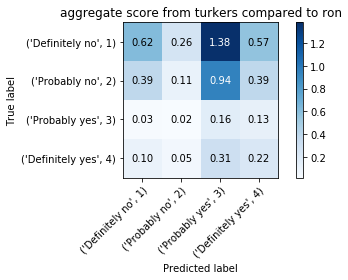

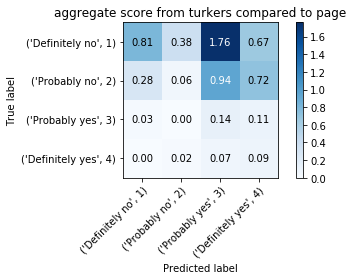

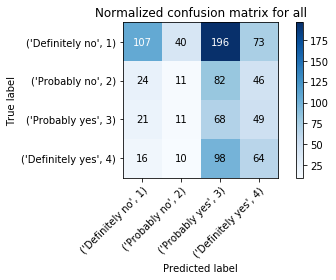

In [45]:
# CONFUSION matrix from averages


imlabels = {}
mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'
gt_total = []
actual_total = []
# load and refactor the annotation data
json_pattern = '*annotations.json'
file_list = glob.glob(json_pattern)
for file in file_list:
    imlabels = {}

    annotations = json.load(open(file))
    # print(annotations)

    # read from expert annotations
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
    #     print(imIds[0])
        if imFn in imlabels.keys():
            imlabels[imFn].append(int(ann['answers']['dianthus']))
        else:
            imlabels[imFn] = [int(ann['answers']['dianthus'])]


# read from turkers labels
    with open('output.manifest', 'r') as input_fid:
        pred = input_fid.readlines()
        det = [ast.literal_eval(x.strip('\n')) for x in pred]


    for item in det:
        imFn = int(item['source-ref'][26:32])
        label = int(labels[item['test-label-dianthus-metadata']['class-name']])
        confidence = float(item['test-label-dianthus-metadata']['confidence'])

        imlabels[imFn].append(label)

    
    # plt.plot(imlabels.keys(),y)
    lists = sorted(imlabels.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    gt = []
    actual = []
    for pt in y:
        gt.append(pt[0])
        actual.append(pt[1])
        gt_total.append(pt[0])
        actual_total.append(pt[1])
    title = 'aggregate score from turkers compared to %s' % file.split('-')[0]
    plot_confusion_matrix(gt, actual, True, title)
title = 'Normalized confusion matrix for all'
print(len(gt_total))
plot_confusion_matrix(gt_total, actual_total, False, title)
# sum

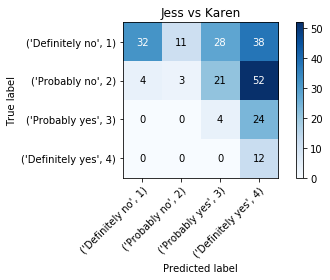

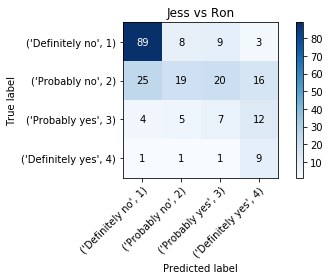

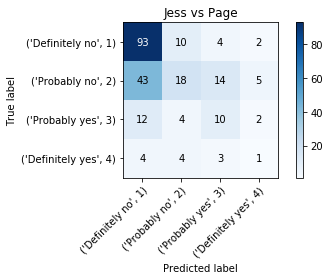

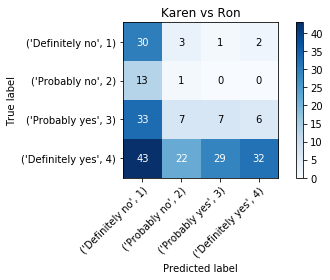

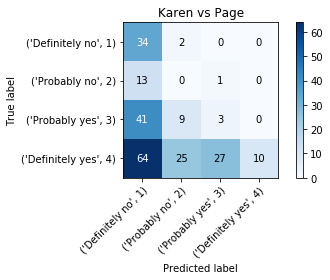

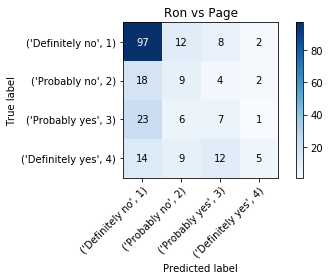

In [87]:
# CONFUSION matrix from averages


imlabels = {}
mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'
gt_total = []
actual_total = []
# load and refactor the annotation data
json_pattern = '*annotations.json'
file_list = glob.glob(json_pattern)
for file in file_list:
    imlabels = {}

    annotations = json.load(open(file))
    # print(annotations)

    # read from expert annotations
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
    #     print(imIds[0])
        if imFn in imlabels.keys():
            imlabels[imFn].append(int(ann['answers']['dianthus']))
        else:
            imlabels[imFn] = int(ann['answers']['dianthus'])

    # plt.plot(imlabels.keys(),y)
    lists = sorted(imlabels.items()) # sorted by key, return a list of tuples
    
    x, y = zip(*lists) # unpack a list of pairs into two tuples
#     gt = []
    actual = []
#     print(y)
#     for i, pt in enumerate(y):
    gt_total.append(y)

#     title = 'aggregate score from turkers compared to %s' % file.split('-')[0]
#     plot_confusion_matrix(gt, actual, True, title)
# title = 'Normalized confusion matrix for all'
# print(len(gt_total))

# ax = plot_confusion_matrix(gt_total[0], gt_total[1], False, 'Jess vs Karen')

# plt.subplot(2, 1, 1)

# fig2 = plt.figure()
# fig2.axes.append(ax)

# for i in range(0, 4):
#     for j in range(0, 4)
plot_confusion_matrix(gt_total[0], gt_total[1], False, 'Jess vs Karen')
plot_confusion_matrix(gt_total[0], gt_total[2], False, 'Jess vs Ron')
plot_confusion_matrix(gt_total[0], gt_total[3], False, 'Jess vs Page')
plot_confusion_matrix(gt_total[1], gt_total[2], False, 'Karen vs Ron')
plot_confusion_matrix(gt_total[1], gt_total[3], False, 'Karen vs Page')
plot_confusion_matrix(gt_total[2], gt_total[3], False, 'Ron vs Page')


plt.show()




# sum

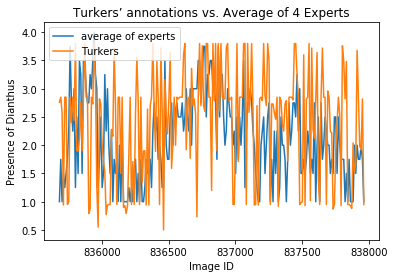

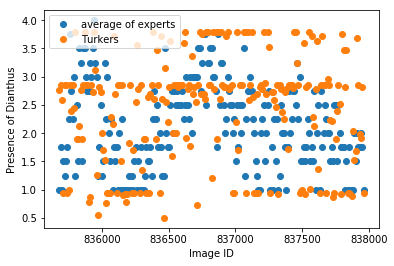

In [46]:
# plot average experts vs. average turkers

imlabels = {}

mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'
imlabels = {}

# load and refactor the annotation data
json_pattern = '*annotations.json'
file_list = glob.glob(json_pattern)
# print(file_list)
for file in file_list:

    annotations = json.load(open(file))
    # print(annotations)

    # read from expert annotations
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
#         print(imlabels.keys())
        if imFn in imlabels.keys():
#             print('why')
            imlabels[imFn].append(int(ann['answers']['dianthus']))
        else:
#             print('why')

            imlabels[imFn] = [int(ann['answers']['dianthus'])]


# read from turkers labels
with open('output.manifest', 'r') as input_fid:
    pred = input_fid.readlines()
    det = [ast.literal_eval(x.strip('\n')) for x in pred]

for item in det:
    imFn = int(item['source-ref'][26:32])
    label = int(labels[item['test-label-dianthus-metadata']['class-name']])
    confidence = float(item['test-label-dianthus-metadata']['confidence'])

    imlabels[imFn].append(label * confidence)
#     imlabels[imFn].append(label)

%matplotlib inline

# plt.plot(imlabels.keys(),y)
lists = sorted(imlabels.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.plot(x, y[0])
# print(imlabels)
legend = ["average of experts", "Turkers"]
plt.figure(0)
plt.plot(x,[sum(pt[0:-1])/len(pt[0:-1]) for pt in y], label = legend[0]) 

# plt.plot(x,[int(sum(pt[0:-1])/len(pt[0:-1])) for pt in y], label = legend[0]) 
plt.plot(x,[pt[-1] for pt in y], label = legend[1]) 

plt.legend()
plt.xlabel('Image ID')
plt.ylabel('Presence of Dianthus')
plt.title('Turkers’ annotations vs. Average of 4 Experts')

plt.figure(1)

plt.plot(x,[sum(pt[0:-1])/len(pt[0:-1]) for pt in y],  'o', label = legend[0]) 

# plt.plot(x,[int(sum(pt[0:-1])/len(pt[0:-1])) for pt in y], 'o', label = legend[0]) 
plt.plot(x,[pt[-1] for pt in y], 'o', label = legend[1]) 

plt.legend()
plt.xlabel('Image ID')
plt.ylabel('Presence of Dianthus')

plt.show()

# print(imlabels)

1.1172828336837684


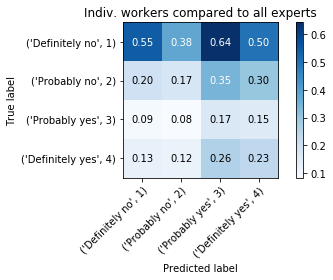

In [47]:
# plot confusion matrix of all workers' labels compared to all experts' labels
y = []
gt = []

imlabels = {}
mappingFile = "abe213a-toid.yaml"
annIdToImId = yaml.load(open(mappingFile))
url_template = 'http://s3.amazonaws.com/visipedia/images/%d/original.jpg'
imlabels = {}

# load and refactor the annotation data
json_pattern = '*annotations.json'
file_list = glob.glob(json_pattern)
# print(file_list)
for file in file_list:

    annotations = json.load(open(file))
    # print(annotations)

    # read from expert annotations
    for annId, ann in annotations:
        imFn = annIdToImId[str(annId)]
#         print(imlabels.keys())
        if imFn in imlabels.keys():
#             print('why')
            imlabels[imFn].append(int(ann['answers']['dianthus']))
        else:
#             print('why')

            imlabels[imFn] = [int(ann['answers']['dianthus'])]

for im in turk_labels:
        for val in turk_labels[im]:
            for value in imlabels[im]:
                y.append(val)
                gt.append(value)

plot_confusion_matrix(gt, y, True, 'Indiv. workers compared to all experts')

In [ ]:
#create dictionaries: 
    # 1) from image ID to annotations by all 9 workers (turk_labels)
    # 2) from workerID to their annotations (workers)


# get raw annotations
annotations = {}


s3 = boto3.resource('s3')
mybucket = s3.Bucket("myra-exp-outputs")
bucket_prefix="test-label-dianthus/annotations/worker-response"
objs = mybucket.objects.filter(
    Prefix = bucket_prefix)

for obj in objs:
    path, filename = os.path.split(obj.key)
    try:
        os.makedirs(path) 
    except FileExistsError:
        pass
#     obj.get()['Key'].read
    parent = path.rsplit('/', 1)[-1]
    parent = int(parent)
    content = ast.literal_eval(obj.get()['Body'].read().decode('utf-8'))
    annotations[parent] = content

#     map ID to 9 diff ratings
turk_labels = {}

# print(len(annotations))
for key, ann in annotations.items():
#     score = 0
    imFn = images[key]
    for ea in ann['answers']:
        label = ea['answerContent']['crowd-image-classifier']['label']
        workerId = ea['workerId']
        lbl = [labels[label], workerId]

        if imFn in turk_labels.keys():
            turk_labels[imFn].append(lbl)
        else:
            turk_labels[imFn] = [lbl]
        
# map worker to their ratings
workers = {}
for key, ann in annotations.items():
    for ea in ann['answers']:
        workerId = ea['workerId']
        label = ea['answerContent']['crowd-image-classifier']['label']
        score = labels[label]
        if workerId in workers.keys():
            workers[workerId].append(score)
        else:
            workers[workerId] = [score]

In [89]:
print(imFn)

836501
